In [1]:
import os
import gym
import math
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import seaborn
#import datetime
#from dateutil.relativedelta import relativedelta   #for leaping forward by 1 year
from collections import namedtuple, deque
from itertools import count
#from PIL import Image
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#from stock_trading_environment import StockTradingEnvironment, Positions

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import config
import psycopg
#import pytz
import pandas as pd
import numpy as np
from psycopg.rows import dict_row

def pgDictToConn(secretDict):
    pgStrs = []
    for key in secretDict:
        pgStrs.append('{}={}'.format(key, secretDict[key]))
    return ' '.join(pgStrs)

#Init
pgConnStr = pgDictToConn(config.pgSecrets)

In [227]:
#copying stock_trading_environment code here for easier editing
#remember to copy back this to the stock_trading environment.py
from gym import spaces
from enum import Enum

class Positions(Enum):   #Python's enum class
    #Short = 0
    #Long = 0
    #Flat = 1
    #Long = 2
    #Short = 2
    Risk_off = 0
    Risk_on = 1


class StockTradingEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, window_size, trade_period, trans_cost):
        super().__init__()

        self.window_size = window_size
        self.trade_period = trade_period
        self.trans_cost = trans_cost
        
        self.trade(data)
        
        # Actions: SHORT(0), FLAT(1), LONG(2)
        #actions: risk_off(0), risk_on(1)
        #self.action_space = spaces.Discrete(3)
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
          low=-np.inf, high=np.inf, shape=(window_size, 1), dtype=np.float16)   #a box as observation space

    #def test(self):
    #    print('testtesttest')
    
    def trade(self, data):
        S1 = data.iloc[:, 0]
        S2 = data.iloc[:, 1]
        _score, self.pvalue, _ = coint(S1, S2)   #probably don't need to include self.pvalue in info; to delete?
        
        #run OLS regression
        ols_model=OLS(S1, S2).fit()
        #get pair's hedge ratio
        self._hr = ols_model.params[0]
            
        #calculate spread
        data['spread'] = np.log(S1) - self._hr * np.log(S2)
        #data['spread'] = S1 - self._hr * S2

        #calculate rolling mean
        data['roll_mean'] = data['spread'].rolling(window=self.window_size, center=False).mean()

        #calculate rolling std
        data['roll_std'] = data['spread'].rolling(window=self.window_size, center=False).std()

        #calculate zscore
        data['zscore'] = (data['spread'] - data['roll_mean'])/data['roll_std']
        
        #exclude the first window length
        self.df = data.iloc[self.window_size:]
        #self.df = data.iloc[60:]   #hard-coding window of 60?
        #self.returns = self.df[['returns1', 'returns2', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)   #tail - last item
        #print(self.returns)
        #return self.returns   #new
        #print('testtestets')

    def reset(self):
        self._done = False
        self._current_tick = self.window_size
        #self._position = Positions.Flat
        self._position = Positions.Risk_off
        self._positionhistory = []
        self._exit_record = [0.0, 0]
        self._total_reward = 0.0
        self._total_return = 0.0
        #self._return = 0.0   #new
        #self.history = {}
        return self.get_observation()
    
    def step(self, action):
        step_reward = 0.0
        step_return = 0.0
        #print(f'self._position: {self._position}')
        #print(f'action: {action}')

        if self._position == Positions.Risk_off:
            if action == Positions.Risk_off:
                step_reward = 0.0
            else:
                self._enter_record = self.enter_trade()
                if self._current_tick - self._exit_record[1] <= 5:   #penalize frequent trading of less than a week
                    step_reward = - np.abs(self._exit_record[0]) * 0.05
                    #step_reward = 0.0
                else:
                    step_reward = 0.0
                #step_reward = 0.1   #some reward to encourage taking risk
                #step_reward = -1   #transaction cost to discourage trading   ###changed###
                self._position = Positions.Risk_on

        elif self._position == Positions.Risk_on:
            if action == Positions.Risk_on:
                step_reward = 0.0
            else:
                #self._return = self.exit_trade(self._enter_record)
                self._exit_record = self.exit_trade(self._enter_record)   #self._exit_record = [pnl, exit_tick]
                step_return = self._exit_record[0]
                
                #penalize frequent trading of less than a week
                if self._current_tick - self._enter_record[2] <= 5:
                    #step_reward = self._return - np.abs(self._return) * 0.2
                    step_reward = self._exit_record[0] - np.abs(self._exit_record[0]) * 0.05   #pnl - 0.05 * pnl
                else:
                    #step_reward = self._return
                    step_reward = self._exit_record[0]
                #print(f'Trade PnL: {self._return}')
                self._position = Positions.Risk_off

        #print(f'step_reward: {step_reward}')
        self._current_tick += 1
        self._positionhistory.append(self._position.value)

        self._position = action   #update self._position with action returned by nn
        #self._done = (self._current_tick + self.trade_period > self.df.shape[0])
        self._done = (self._current_tick + 1 > self.df.shape[0])   #new; no longer need trade_period
        
        self._total_reward += step_reward
        #self._total_return += self._return
        self._total_return += step_return
        #print(f'self._total_return: {self._total_return}')
        
        observation = self.get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_return = self._total_return
        )

        return observation, step_reward, self._done, info
        #return observation, step_reward, self._done
    
    
    def get_observation(self):
        end_index = self._current_tick
        start_index = end_index - self.window_size
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')].values   #zscore = (spread-roll+mean)/roll_std
        return np.append(zscore, [self._position.value, float(self.pvalue)])   #60 zscores + _position.value + pvalue = 62 items in each obs
        #return np.append(zscore, [self._position.value, self._current_tick])   #60 zscores + _position.value + _current_tick = 62 items in each obs


    def enter_trade(self):
        #+ve and -ve directions are a bit counter-intuitive below
        #the logic is: if you short/sell something, your cash level increases by the price
        #if you long/buy something, your cash level decreases by the price
        #this is just for easier calculations: say you short $100 and later it drops to $90, the pnl is +$100-$90=+$10
        #say you long $90 and later it increases to $110, the pnl is -$90+$110=+$20
        #adjusted by hedge ratio

        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2
            self._S1_entry_price = self.df.loc[self.df.index[self._current_tick]][0]               #short/sell
            self._S2_entry_price = -self._hr * self.df.loc[self.df.index[self._current_tick]][1]   #long/buy
        
        else:   #S2 more expensive than S1; should long S1 short S2
            self._S1_entry_price = -self.df.loc[self.df.index[self._current_tick]][0]             #long/buy
            self._S2_entry_price = self._hr * self.df.loc[self.df.index[self._current_tick]][1]   #short/sell

        return [self._S1_entry_price, self._S2_entry_price, self._current_tick]
    

    def exit_trade(self, trade_record):
        
        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2 initially
            #unwind: buy S1 sell S2
            pnl = (trade_record[0] - self.df.loc[self.df.index[self._current_tick]][0]) + \
                (trade_record[1] + self._hr * self.df.loc[self.df.index[self._current_tick]][1]) - self.trans_cost
        
        else:   #S2 more expensive than S1; should long S1 short S2 initially
            #unwind: sell S1 buy S2
            pnl = (trade_record[0] + self.df.loc[self.df.index[self._current_tick]][0]) + \
                (trade_record[1] - self._hr * self.df.loc[self.df.index[self._current_tick]][1]) - self.trans_cost

        #should not penalize here    
        #penalize frequent trading of less than a week
        #if self._current_tick - trade_record[2] <= 5:
        #    pnl = pnl*0.9

        return [pnl, self._current_tick]
           
    
    def render(self, mode='human', close=False):
        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        #mask = pd.Series(self._positionhistory, index=self.df.index[start_index:end_index])
        #mask = pd.DataFrame(self._positionhistory, index=self.df.index[start_index:end_index])    ###changed###
        #short_mask = pd.DataFrame(self._positionhistory[-244:], index=self.df.index[-244:])   #newly created to plot twists
        short_mask = pd.DataFrame(self._positionhistory[-230:], index=self.df.index[-230:])   #newly created to plot twists
        
        
        #new
        short_mask['shift'] = short_mask[0].shift(1).fillna(0)
        short_mask['diff'] = short_mask[0] - short_mask['shift']
        #if diff = +1, from 0 to 1, trade, risk_on
        #if diff = 0, from 0 to 0, or 1 to 1, no trade
        #if diff = -1, from 1 to 0, trade, risk_off


        #self.plot_returns_delta(mask)
        #self.plot_prices(mask)
        #print(short_mask['diff'].unique())
        self.plot_short_prices(short_mask['diff'])
        

        #mask['shift'] = mask[0].shift(1).fillna(0)
        #mask['diff'] = mask[0] - mask['shift']
        #print(mask['diff'].unique())
        #self.plot_short_prices(mask['diff'])


    def plot_returns(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Risk_off.value] = -np.inf
        sell[mask==Positions.Risk_on.value] = -np.inf
        #buy[mask==Positions.Flat.value] = -np.inf
        #sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_returns_delta(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]      ### NEW ###
        
        #return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return1')]
        #return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return2')]
        return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns1')]   ### NEW ###
        return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns2')]   ### NEW ###
        returns_delta = return1 - return2
        returns_delta.plot()
        
        buy = returns_delta.copy()
        sell = returns_delta.copy()
        
        buy[mask==Positions.Risk_on.value] = -np.inf
        sell[mask==Positions.Risk_off.value] = -np.inf
        #buy[mask==Positions.Flat.value] = -np.inf
        #sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Returns Delta', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_zscore(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Short.value] = -np.inf
        sell[mask==Positions.Long.value] = -np.inf
        buy[mask==Positions.Flat.value] = -np.inf
        sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_ratios(self, mask):
        plt.figure(figsize=(12,6))
        
        start_index = self.window_size
        end_index = start_index + len(self._positionhistory)
        ratios = self.df.iloc[start_index:end_index, self.df.columns.get_loc('ratios')]
        ratios.plot()
        
        buy = 0*ratios.copy()
        sell = 0*ratios.copy()
        
        buy[mask==Positions.Long.value] = ratios[mask==Positions.Long.value]
        sell[mask==Positions.Short.value] = ratios[mask==Positions.Short.value]
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, ratios.min(), ratios.max()))
        
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        S1 = self.df.iloc[start_index:end_index, 0]
        S2 = self.df.iloc[start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        buyR = 0*S1.copy()
        sellR = 0*S1.copy()

        # When you buy the ratio, you buy stock S1 and sell S2
        buyR[mask==Positions.Long.value] = S1[mask==Positions.Long.value]
        sellR[mask==Positions.Long.value] = S2[mask==Positions.Long.value]

        # When you sell the ratio, you sell stock S1 and buy S2
        buyR[mask==Positions.Short.value] = S2[mask==Positions.Short.value]
        sellR[mask==Positions.Short.value] = S1[mask==Positions.Short.value]

        buyR.plot(color='r', linestyle='None', marker='^')
        sellR.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_short_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #short_start_index = len(self._positionhistory) - 244   #to shorten the plot
        #short_start_index = -244   #to shorten the plot
        short_start_index = -230   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        #S1 = self.df.iloc[start_index:end_index, 0]
        #S2 = self.df.iloc[start_index:end_index, 1]
        S1 = self.df.iloc[short_start_index:end_index, 0]
        S2 = self.df.iloc[short_start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        #buyR = 0*S1.copy()
        #sellR = 0*S1.copy()
        buy_ron = 0*S1.copy()
        sell_ron = 0*S1.copy()
        buy_roff = 0*S1.copy()
        sell_roff = 0*S1.copy()

        #if diff = +1, from 0 to 1, trade, risk_on
        #if diff = 0, from 0 to 0, or 1 to 1, no trade
        #if diff = -1, from 1 to 0, trade, risk_off
        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2
            #risk_on
            sell_ron[mask==1] = S1[mask==1]
            buy_ron[mask==1] = S2[mask==1]

            #risk_off
            buy_roff[mask==-1] = S1[mask==-1]
            sell_roff[mask==-1] = S2[mask==-1]


        else:   #S2 more expensive than S1; should long S1 short S2
            #risk_on
            buy_ron[mask==1] = S1[mask==1]
            sell_ron[mask==1] = S2[mask==1]

            #risk_off
            sell_roff[mask==-1] = S1[mask==-1]
            buy_roff[mask==-1] = S2[mask==-1]


        buy_ron.plot(color='g', linestyle='None', marker='^')
        sell_ron.plot(color='r', linestyle='None', marker='v')
        buy_roff.plot(color='g', linestyle='None', marker='x')
        sell_roff.plot(color='r', linestyle='None', marker='x')
        #buyR.plot(color='g', linestyle='None', marker='^')
        #sellR.plot(color='r', linestyle='None', marker='v')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Risk-on', 'Sell Risk-on', 'Buy Risk-off', 'Sell Risk-off'])
        plt.show()

        

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    hr = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)    #statsmodel built-in cointegration hypothesis test
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue

            #run OLS regression
            ols_model=OLS(S1, S2).fit()
            #get pair's hedge ratio
            hr_pair = ols_model.params[0]
            
            #calculate spread
            spread = np.log(S1) - hr_pair * np.log(S2)
            #spread = S1 - hr_pair * S2   ###changed###

            #adf
            # conduct Augmented Dickey-Fuller test
            adf = adfuller(spread, maxlag = 1)
        
            #if pvalue < 0.05 :    #reject null: there should be cointegration
            #add one condition: adf needs to < -3.435 to confirm stationarity
            if (pvalue < 0.05 and adf[0] < -3.435):    #reject null: there should be cointegration
                pairs.append((keys[i], keys[j]))
                
                #append hr_pair into hr list
                hr.append(hr_pair)
     
    return score_matrix, pvalue_matrix, hr, pairs


def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [5]:
###new###
def getDailyPrices(symbol_lst):
    df = pd.DataFrame()

    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            for symbol in symbol_lst:
                stmt = '''SELECT tranx_date, close FROM alpaca_daily_selected WHERE symbol = %s'''
                data = (symbol, )
                cur.execute(stmt, data)
                rows = cur.fetchall()
                ticker_df = pd.DataFrame(rows, columns=['tranx_date',symbol])
                ticker_df.drop_duplicates(subset=['tranx_date']).set_index('tranx_date')   ###alpaca data may have duplicate prices for the same datetime###
                df = pd.concat([df, ticker_df[symbol]], axis=1)
                
    #df.to_csv('DailyDF', index=False)

    return df


In [6]:
###new###
def getDailyPricesTickersLst():
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            stmt = '''SELECT DISTINCT symbol FROM alpaca_daily_selected'''
            result = cur.execute(stmt).fetchall()
            result = [res[0] for res in result]
    return result

In [7]:
###find clusters of stocks from dailyDF###
###using kmeans and PCA###
def findStockClusters(df, n_clusters):
    
    #need to convert all values to numeric values first
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Interpolate missing values using linear interpolation
    df = df.interpolate(method='linear', axis=0).ffill().bfill().fillna(0).drop_duplicates()

    # Fit KMeans clustering model to the dataframe
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df.T)   #to find clusters by columns

    # Get cluster labels for each stock
    labels = kmeans.labels_
    
    # Use PCA to reduce the dataframe to 2 dimensions
    pca = PCA(n_components=2)
    coords = pca.fit_transform(df.transpose())

    # Create a dataframe with the stock symbols, their corresponding cluster label, and their 2D coordinates
    clusters = pd.DataFrame({'symbol': df.columns, 'cluster': labels, 'x': coords[:, 0], 'y': coords[:, 1]})

    return clusters

In [8]:
###filter out some outlier clusters###
###generate a dict of good clusters###
def findStocksinClusters(clusters, n):
    good_clusters = []
    good_clusters_dict = {}

    for i in range(n):
        if len(clusters[clusters['cluster']==i]) >= 5:
            good_clusters.append(i)

    for cluster in good_clusters:
        good_clusters_dict[cluster] = clusters[clusters['cluster']==cluster]['symbol'].reset_index()['symbol']

    return good_clusters_dict

In [13]:
###new###
def plotStockClusters(clusters):
    # Get unique cluster labels
    unique_clusters = np.unique(clusters['cluster'])

    # Create a color map for the clusters
    cmap = plt.get_cmap('viridis', len(unique_clusters))

    # Plot the scatter plot with each cluster colored differently
    fig, ax = plt.subplots(figsize=(8,6))
    for i, cluster in enumerate(unique_clusters):
        x = clusters.loc[clusters['cluster'] == cluster, 'x']
        y = clusters.loc[clusters['cluster'] == cluster, 'y']
        symbol = clusters.loc[clusters['cluster'] == cluster, 'symbol']
        ax.scatter(x, y, label=f"Cluster {cluster}", color=cmap(i))
        #for j, sym in enumerate(symbol):
        #    ax.annotate(sym, (x.iloc[j], y.iloc[j]))

    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend()
    plt.show()

In [24]:
###new heatmap function###
###find cointegration###
def cointHeatmap(df):

    # Randomly sample 50 columns if df too long
    if len(df) >= 50:
        sampled_df = df.sample(n=50, axis=1)
    else:
        sampled_df = df
    
    tickers = sampled_df.columns
    scores, pvalues, hr, pairs = find_cointegrated_pairs(sampled_df)
    
    fig, ax = plt.subplots(figsize=(10,10))
    seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
    print(pairs)
    return pairs, pvalues, sampled_df

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


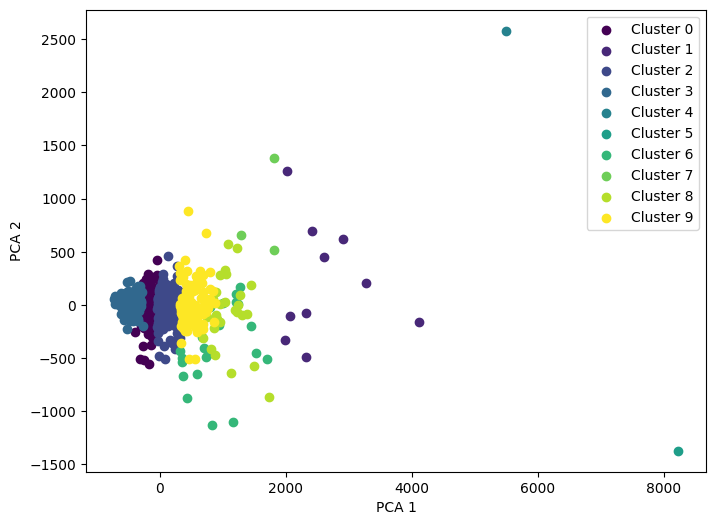

In [15]:
###dovetail###
'''
Read filtered stocks closing prices as CSV/in SQL
Find clusters with kmeans and PCA
Filter out some outlier clusters; key clusters # as a dict
Find cointegration of each key cluster and plot heatmap
'''
n_clusters = 10
#dailyDF = pd.read_csv('./data/dailyDF', header=0)#, index_col=0, skiprows=0)
dailyDF = getDailyPrices(getDailyPricesTickersLst())
clusters = findStockClusters(dailyDF, n_clusters)
good_clusters_dict = findStocksinClusters(clusters, n_clusters)
plotStockClusters(clusters)
#for key in good_clusters_dict.keys():
#    cointHeatmap(FilteredClosingDF[good_clusters_dict[key]])
#cointHeatmap(FilteredClosingDF[good_clusters_dict[0]])

In [70]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 321 stocks
cluster 1: 10 stocks
cluster 2: 258 stocks
cluster 3: 315 stocks
cluster 6: 22 stocks
cluster 8: 30 stocks
cluster 9: 121 stocks


[('AUBN', 'LZB'), ('BLTE', 'SOHU'), ('BLTE', 'JRVR'), ('BLTE', 'STEL'), ('BLTE', 'AAT'), ('BLTE', 'HNI'), ('BLTE', 'MOFG'), ('BLTE', 'PFC'), ('BLTE', 'PETS'), ('BLTE', 'TBNK'), ('DMRC', 'FLXS'), ('STEL', 'PEBO'), ('DWAC', 'SCHN'), ('DWAC', 'LZB'), ('SAL', 'MOFG'), ('SAL', 'PETS'), ('SAL', 'REYN'), ('GOOS', 'PEBO'), ('GOOS', 'PARAP'), ('GOOS', 'EQBK'), ('MOFG', 'LZB'), ('MOFG', 'REYN'), ('MOFG', 'RNST'), ('SCSC', 'EQBK'), ('SCSC', 'RNST'), ('BTAI', 'PARAP'), ('PFC', 'QURE'), ('PFC', 'NWFL'), ('PFC', 'TBNK'), ('LZB', 'REYN'), ('NWFL', 'TBNK')]


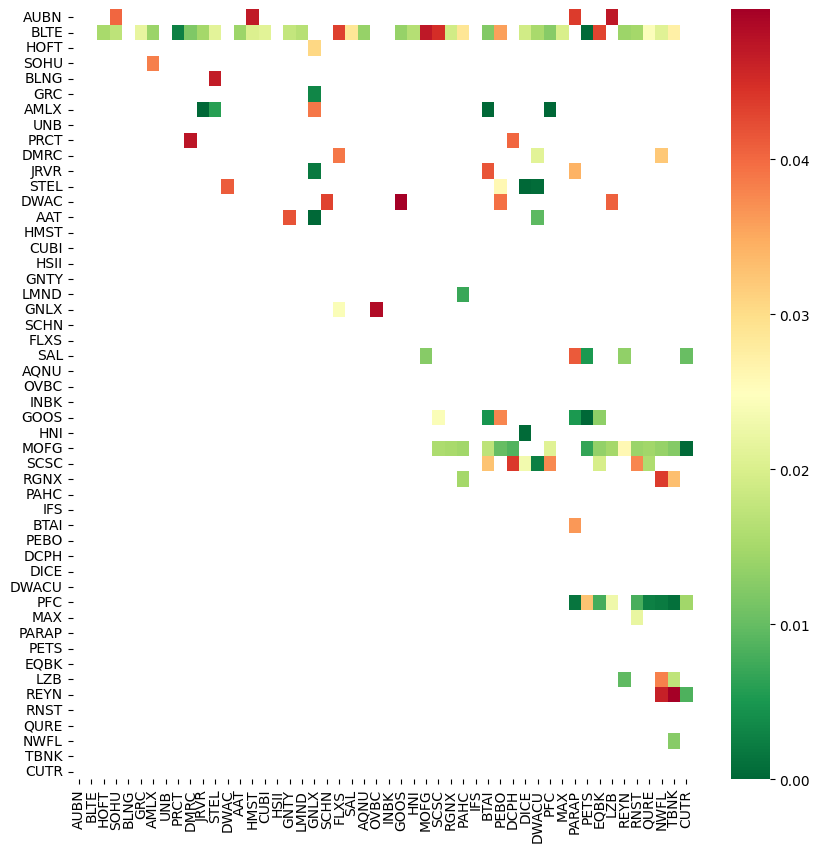

In [17]:
###split train/test data by time: 70/30###
#select which cluster
trainpairs, trainpval, traindf = cointHeatmap(dailyDF[good_clusters_dict[9]].loc[:round(len(dailyDF)*0.7)].dropna(axis=1, how='all'))

In [71]:
trainpairs

[('AUBN', 'LZB'),
 ('BLTE', 'SOHU'),
 ('BLTE', 'JRVR'),
 ('BLTE', 'STEL'),
 ('BLTE', 'AAT'),
 ('BLTE', 'HNI'),
 ('BLTE', 'MOFG'),
 ('BLTE', 'PFC'),
 ('BLTE', 'PETS'),
 ('BLTE', 'TBNK'),
 ('DMRC', 'FLXS'),
 ('STEL', 'PEBO'),
 ('DWAC', 'SCHN'),
 ('DWAC', 'LZB'),
 ('SAL', 'MOFG'),
 ('SAL', 'PETS'),
 ('SAL', 'REYN'),
 ('GOOS', 'PEBO'),
 ('GOOS', 'PARAP'),
 ('GOOS', 'EQBK'),
 ('MOFG', 'LZB'),
 ('MOFG', 'REYN'),
 ('MOFG', 'RNST'),
 ('SCSC', 'EQBK'),
 ('SCSC', 'RNST'),
 ('BTAI', 'PARAP'),
 ('PFC', 'QURE'),
 ('PFC', 'NWFL'),
 ('PFC', 'TBNK'),
 ('LZB', 'REYN'),
 ('NWFL', 'TBNK')]

In [20]:
len(trainpairs)

31

In [19]:
trainpval.shape

(50, 50)

In [238]:
###create trainenvs###
window_size = 60
trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()


In [81]:
len(trainenvs)

22

In [82]:
###val set heatmap###
#Remember to use the same cluster as train set
valpairs, valpval, valdf = cointHeatmap(dailyDF[good_clusters_dict[9]].loc[round(len(dailyDF)*0.7):].dropna(axis=1, how='all'))

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


[('STEL', 'CUBI'), ('UNFI', 'PAM'), ('UNFI', 'DCPH'), ('UNFI', 'SGA'), ('EQBK', 'TRMK'), ('JRVR', 'XNCR'), ('AUBN', 'HURC'), ('PEBO', 'WLDN'), ('PAM', 'SGA'), ('HURC', 'UNB'), ('FMAO', 'DXPE'), ('ATEX', 'WLDN')]


In [27]:
len(valpairs)

8

In [239]:
###create valenvs###
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()

In [29]:
len(valenvs)

8

In [30]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [31]:
class DQN(nn.Module):   #PyTorch's Module class

    def __init__(self, input_size, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x.to(device))

In [243]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
#n_actions = 3
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)   #decreasing from 1 to 0.36xxx
    steps_done += 1
    if sample > eps_threshold:   #epsilon-greedy: at first, more random less nn; gradually more nn less random
        with torch.no_grad():   #disable tracking of grad in autograd; reduce memory usage and speed up computations; no backprop
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state)).max(1)
            return policy_net(state).max(1)[1].view(1, 1)   #exploit
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)   #explore, because random

In [33]:
def optimize_model():
    if len(memory) < BATCH_SIZE:   #min memory = 128
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))   #batch is a namedtuple; tuple (state, action, next_state, reward) from memory

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,   #lambda s: s is not None will return a tuple of bools over bench.next_state
                                          batch.next_state)), device=device, dtype=torch.bool)   #next_state is an observation
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #Q(s_t, a) is what the policy_net says based on state_batch
    state_action_values = policy_net(state_batch).gather(1, action_batch)   #gather from policy_net(state_batch) (axis, index)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)   #initialize next_state_values
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()   #what target_net says
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch   
    #Bellman equation: expected state_action values (from target network) * GAMMA + immediate reward should equal to
    #state_action values returned by policy network; difference = loss

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()   #set optimizer's grad to zero
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)   #clamp_ is inplace version of clamp: clamp grad.data into -1 and 1 range
    optimizer.step()   #update parameters of optimizer

In [244]:
###training agent###
num_episodes = 300
#num_episodes = 10
best_rewards = -10
for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)   
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = select_action(state)   #epsilon-greedy: exploit or explore; state is this state
            obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each status means 60 past zscores + current action + pvalue  
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            #new
            #train_rewards.append(reward)


            # Perform one step of the optimization (on the policy network)
            optimize_model()   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, _reward, done, info = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns)))
    #print('epoch [{}/{}], train rewards:{:.4f}, val rewards:{:.4f}'.format
    #      (i_episode + 1, num_episodes, np.mean([float(x) for x in train_rewards]), #not all in train_rewards are torch.Tensor
    #       np.mean([float(x) for x in test_rewards])))
           #np.mean(np.sum([float(x) for x in test_rewards]))))


print('Complete')

epoch [1/300], train rewards:-27.3014, returns:-9.7184, val rewards:5.0297, returns:8.1904
epoch [2/300], train rewards:-40.2130, returns:-20.0017, val rewards:-5.6801, returns:0.7517
epoch [3/300], train rewards:-36.4025, returns:-14.9716, val rewards:-11.3670, returns:-5.8696
epoch [4/300], train rewards:-35.7728, returns:-16.0809, val rewards:-11.7543, returns:-4.6426
epoch [5/300], train rewards:-29.9733, returns:-8.0349, val rewards:-12.3365, returns:-5.7682
epoch [6/300], train rewards:-35.1450, returns:-13.9659, val rewards:-11.3592, returns:-5.0544
epoch [7/300], train rewards:-42.0507, returns:-18.7411, val rewards:-10.0975, returns:-2.5333
epoch [8/300], train rewards:-40.2682, returns:-16.5884, val rewards:-11.8258, returns:-5.8597
epoch [9/300], train rewards:-38.2497, returns:-15.2624, val rewards:-9.9426, returns:-3.6223
epoch [10/300], train rewards:-36.6069, returns:-14.7023, val rewards:-6.8060, returns:-1.1165
epoch [11/300], train rewards:-45.3070, returns:-22.1947, 

In [85]:
valenvs

In [140]:
valenvs[0]._trade_record

[-39.65, 48.1483455822014, 451]

In [141]:
valenvs[0]._current_tick

493

In [146]:
valenvs[0]._hr

0.6928816460239086

In [189]:
valenvs[1]._positionhistory

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [167]:
[i for i, x in enumerate(valenvs[0]._positionhistory) if x == 1]

[256, 257]

In [172]:
valenvs[0]._return

0.7992881646023875

In [170]:
valenvs[0]._total_return

139.8754288054178

In [161]:
valenvs[0]._positionhistory

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [154]:
valenvs[0].df

,UNFI,PAM,spread,roll_mean,roll_std,zscore
1349,21.28,22.75,0.892814,0.572592,0.194010,1.650545
1350,21.16,22.28,0.901623,0.586340,0.187393,1.682476
1351,20.52,21.76,0.887274,0.596533,0.186841,1.556088
1352,19.91,22.30,0.840111,0.598989,0.189082,1.275223
1353,20.52,22.48,0.864719,0.605472,0.191438,1.354203
...,...,...,...,...,...,...
1837,40.15,61.30,0.840874,0.828917,0.056558,0.211420
1838,40.29,61.01,0.847641,0.829120,0.056603,0.327198
1839,41.22,61.50,0.864918,0.828910,0.056444,0.637948
1840,41.24,60.53,0.876419,0.828071,0.055328,0.873835


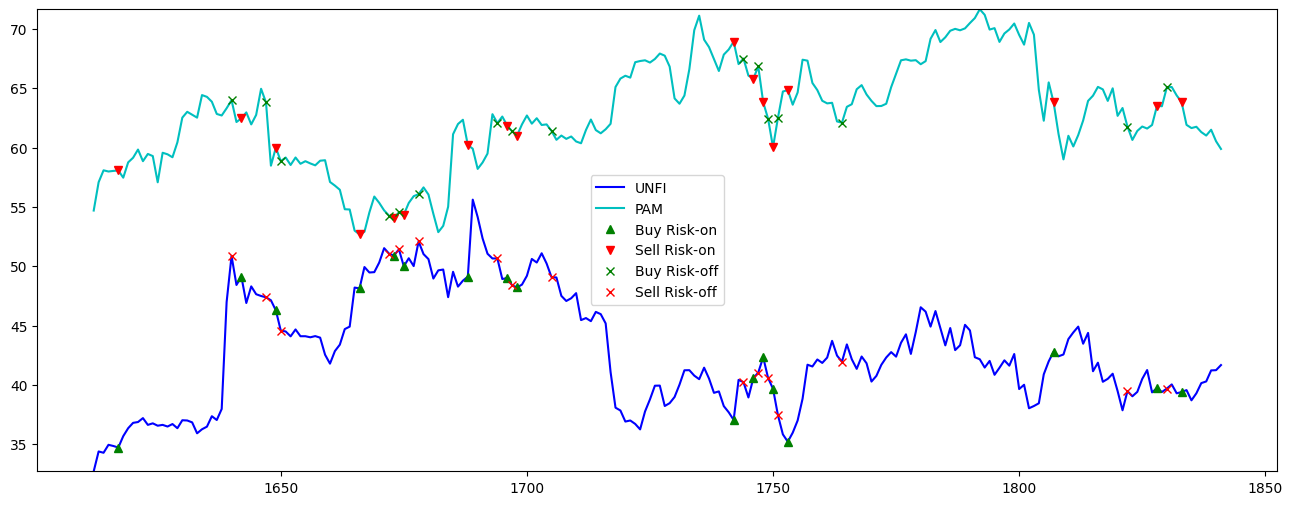

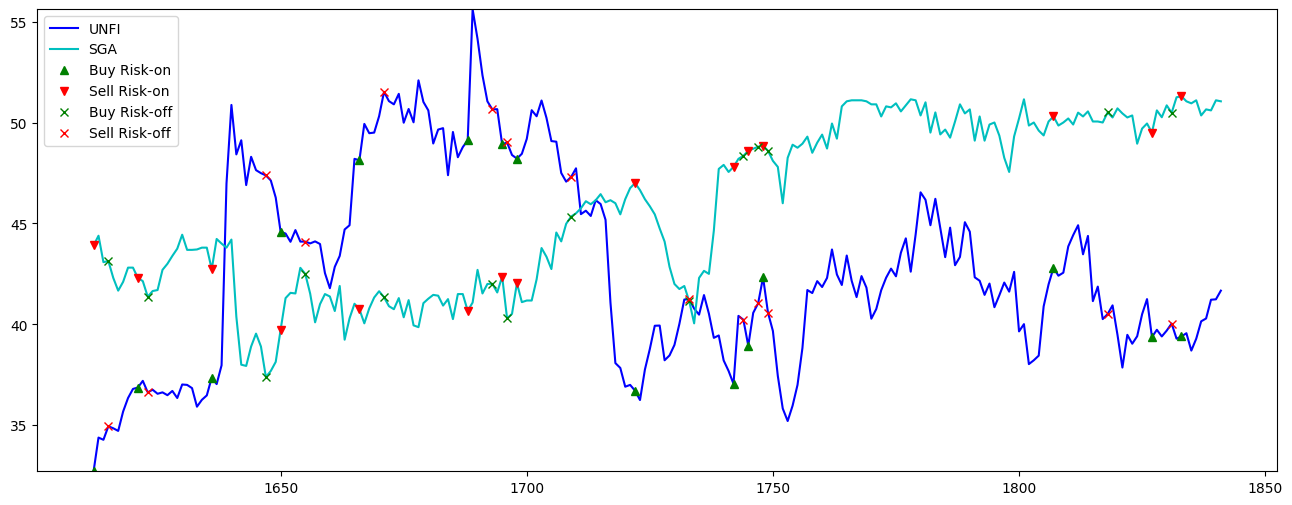

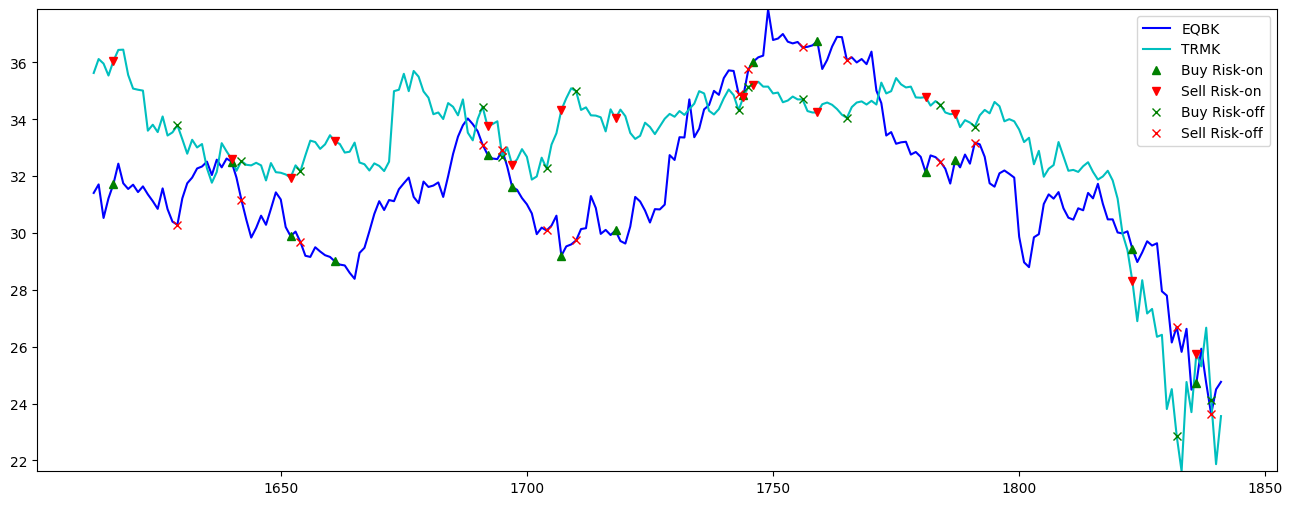

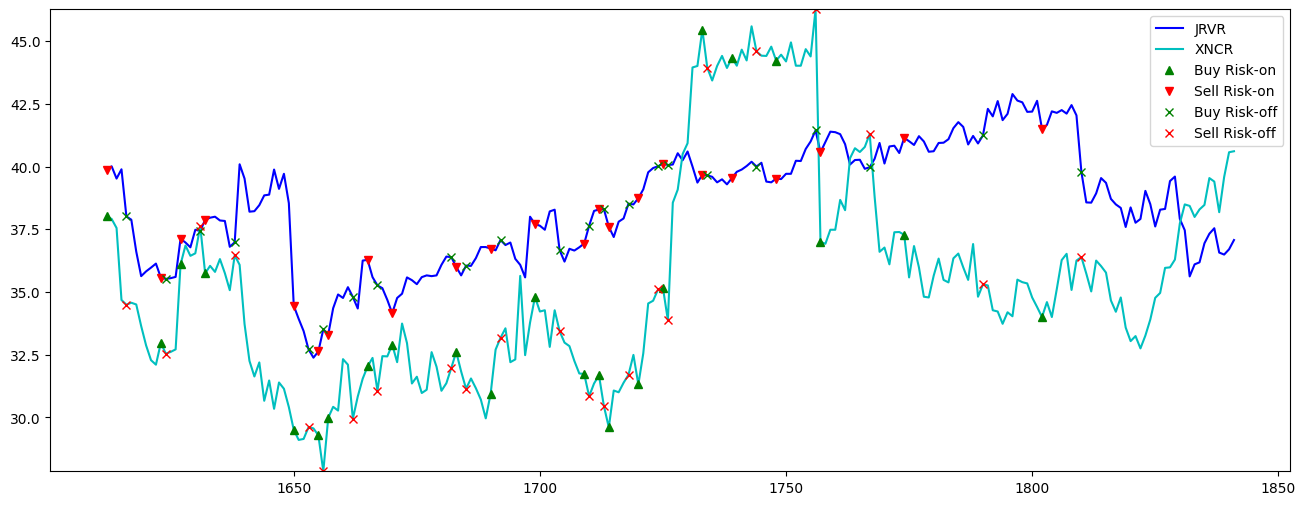

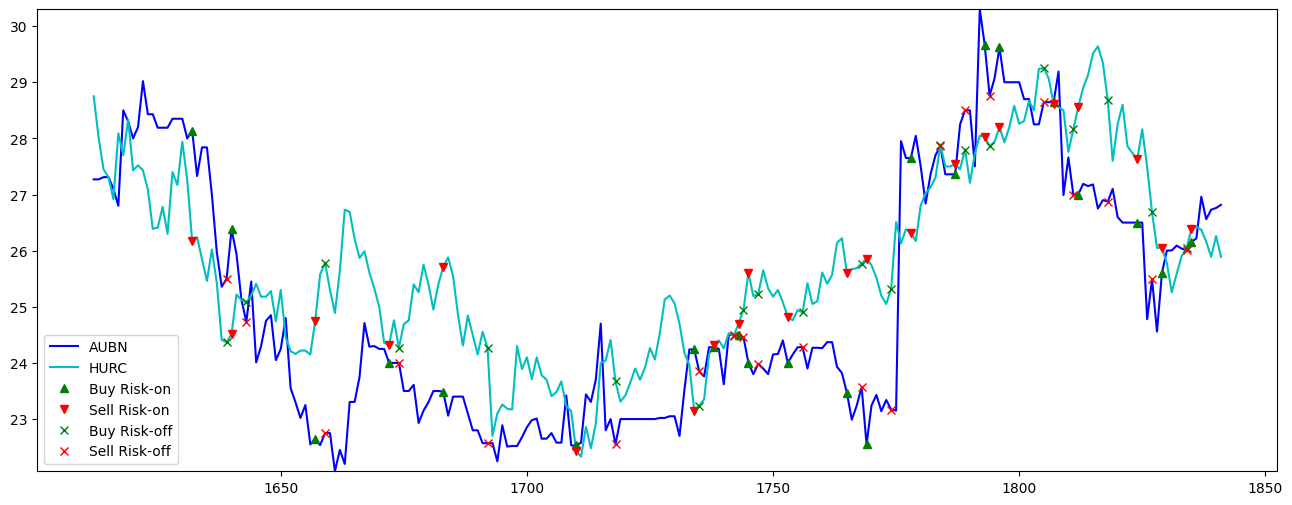

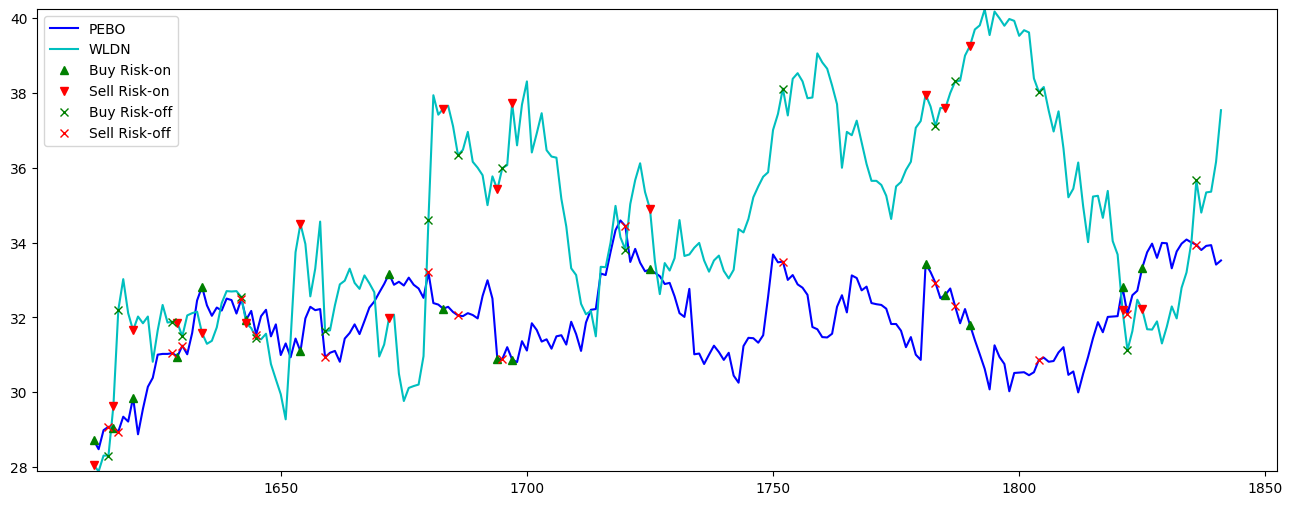

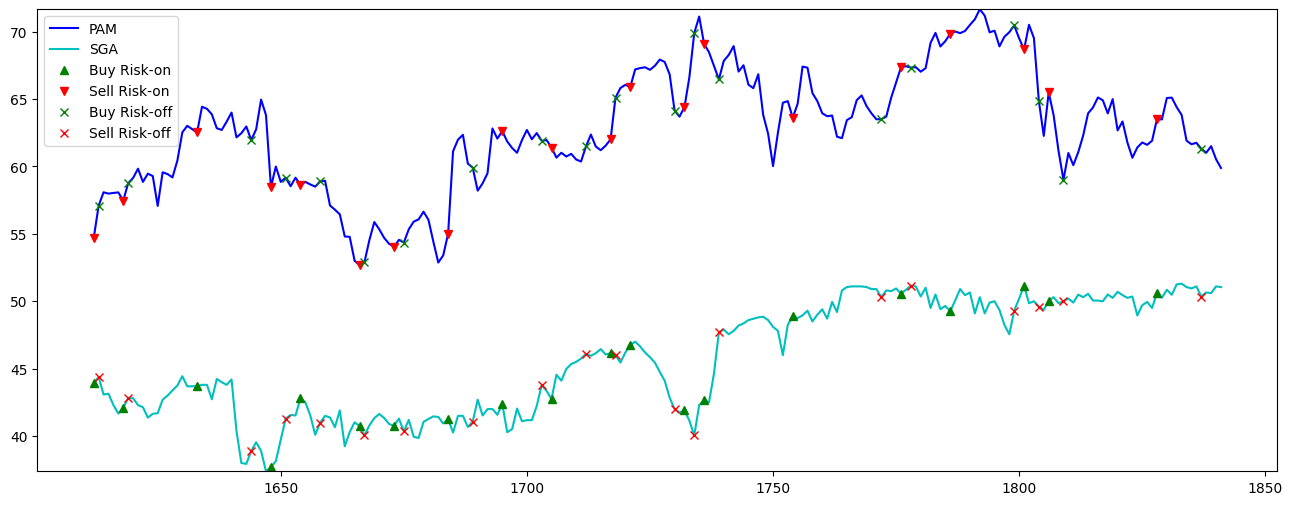

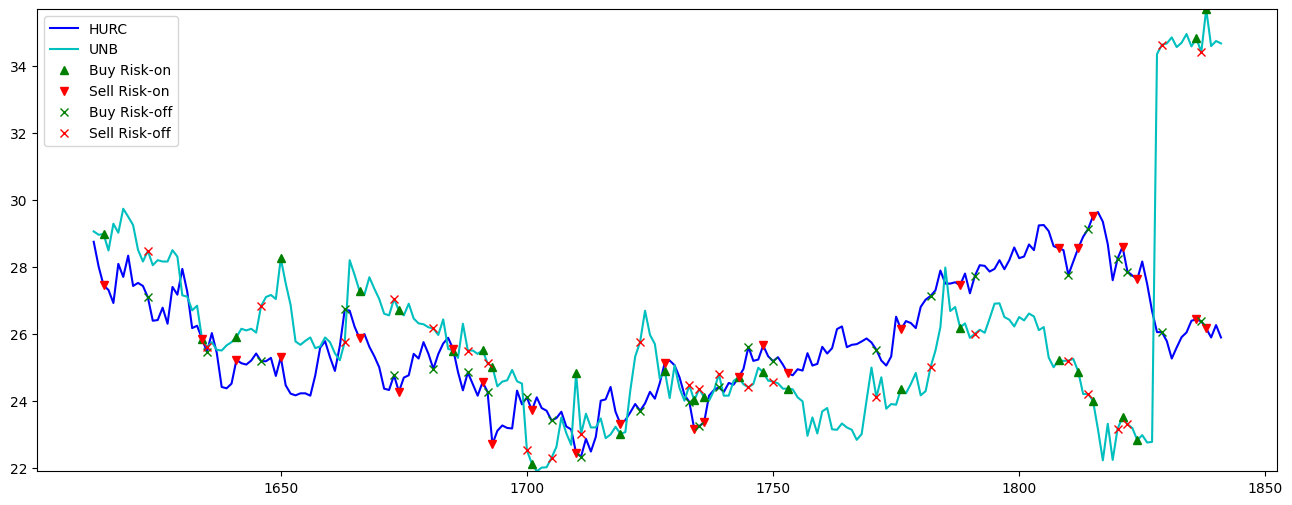

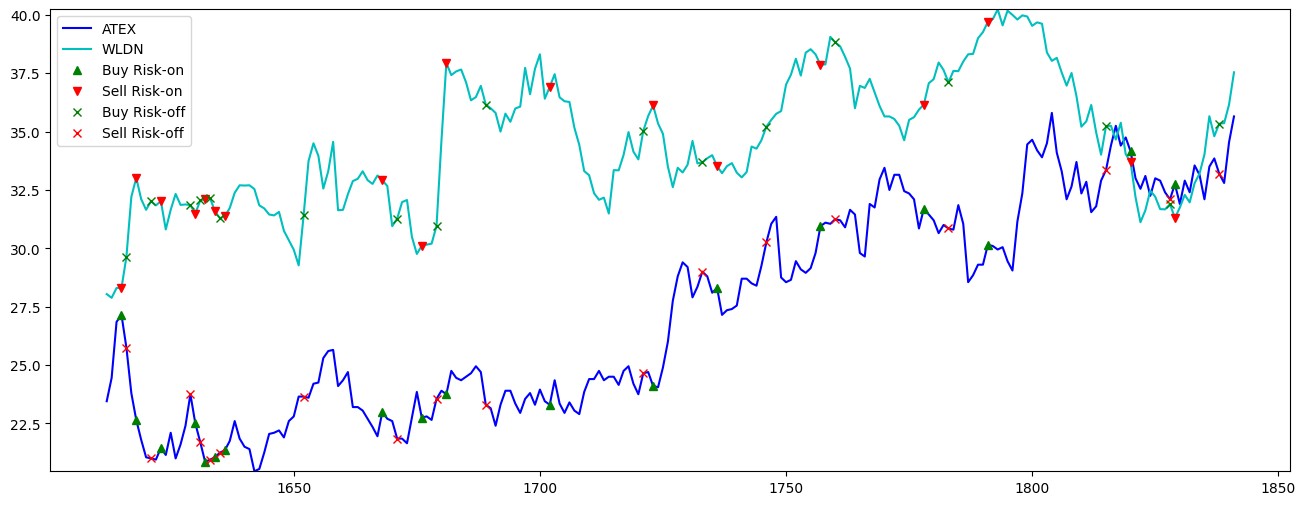

average returns: 8.19042704324572


In [245]:
###plot###
#fill in latest model
policy_net.load_state_dict(torch.load('./models/model (29).pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

total_returns = []
with torch.no_grad():
    for valenv in valenvs:
        obs = valenv.reset()
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = valenv.step(Positions(action.item()))
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            
            if done:
                #print(f'env.returns\n{env.returns}')
                #print(f'env.total_reward{env._total_reward}')
                valenv.render()   #only rendering the last year
                #total_returns.append(returns)   ###changed###
                #print(f'returns: {np.sum(returns)}')   ###changed###
                #total_returns.append(np.sum(returns))   ###changed###
                #print(f'len(returns): {len(returns)}')
                total_returns.append(info['total_return'])
                break

#print(f'returns: {returns}')
#avg_returns = np.mean(returns)
#print(f'average returns: {np.mean(np.sum(total_returns))}')
print(f'average returns: {np.mean(total_returns)}')

plt.ioff()
plt.show()

In [72]:
test_envs[0]._pnl

-0.36853491920708414

In [97]:
for i in range(16):
    print(np.unique(np.array(envs[i]._positionhistory)))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
